# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
# * import sys
# Import the sys module, which is a Python standard library module.
# This module provides access to variables and functions that interact strongly with the
# Python interpreter, such as manipulating module search path and input/output
# standard, among others.
# * sys.path
# It is a list containing the paths in which the Python interpreter looks for modules when
# you use import. When you try to import a module, Python searches the paths specified in this
# list.
# * sys.path.insert(0, '..')
# Insert the path '..' (representing the parent directory) at the beginning of the sys.path list.
# Adding it in position 0 ensures that when Python looks for modules to import,
# first check in the parent directory before continuing with the default paths.

import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
# * from python_environment_check import check_packages
# Import the check_packages function from the python_environment_check module. 
# This module, from its name, appears to be designed to verify that the Python environment 
# have the correct versions of certain packages installed.
# * d = {...}
# Defines a dictionary d that contains the names of several packages as keys 
# (e.g. numpy, scipy, matplotlib, etc.) and as values ​​the minimum versions 
# required from those packages.
# * check_packages(d)
# The check_packages function takes as input the dictionary d and probably performs a 
# check on current Python environment to ensure installed versions 
# of these packages are at least those specified in the dictionary. If any of the packages 
# is not installed or has the wrong version, the function may throw an error or 
# suggest installing/updating the packages.

from python_environment_check import check_packages
d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2'
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


[OK] numpy 1.24.3
[OK] matplotlib 3.5.1
[OK] sklearn 1.5.2
[OK] pandas 2.2.2


# Example 7 - LDA (Linear Discriminant Analysis) Exercise

### Overview

- [Importing libraries for data analysis and scaling](#importing-libraries-for-data-analysis-and-scaling)
- [Extracting the principal components step by step](#extracting-the-principal-components-step-by-step)
- [Computing the scatter matrices](#computing-the-scatter-matrices)
- [Selecting linear discriminants for the new feature subspace](#selecting-linear-discriminants-for-the-new-feature-subspace)
- [Projecting examples onto the new feature space](#projecting-examples-onto-the-new-feature-space)
- [LDA via scikit-learn](#lda-via-scikit-learn)
- [Summary](#summary)

STATEMENT

- In this exercise, you will perform a linear discriminant analysis (LDA) using the data set provided in the 'dataset1.csv' file.

- The analysis will be carried out in two different ways: First through a manual implementation (without using specific LDA libraries) and later using scikit-learn.

- For both cases, you must calculate the linear discriminants considered and obtain the weight matrix (W) and the projections (X').

- Additionally, you must create visualizations that show the projections (X') labeled according to their category.

- Finally, you will compare the results obtained by both methods.

In [3]:
# * from IPython.display
# Import from the display submodule of the IPython package. This module is designed to display 
# and render different types of data within interactive environments, such as Jupyter Notebooks.
# * import Image
# Import the Image class from the display module. The Image class is used to display 
# images in the interactive environment (for example, in a Jupyter Notebook cell).
# * %matplotlib inline
# This is a magic command specific to IPython/Jupyter Notebook.
# Enables display of matplotlib plots directly within cells of the 
# notebook. Graphics are rendered "inline" (within the same notebook) without the need 
# to open pop-up windows.

from IPython.display import Image
%matplotlib inline

## Importing libraries for data analysis and scaling

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Extracting the principal components step by step

In [5]:
# Download the wine dataset from the UCI Machine Learning Repository
df = pd.read_csv('dataset1.csv')

In [6]:
# Show the first five rows of the dataset
df.head()

,Col7,Col5,Col2,Col4,Col8,Col3,Col6,Col1,Target
0,20.8,0.733,48,9,22,120,72,56,0
1,32.0,0.444,42,1,29,100,66,196,0
2,34.8,0.217,24,1,45,112,80,132,0
3,31.0,0.874,21,0,16,113,80,0,0
4,26.2,0.313,41,6,30,80,66,0,0


In [7]:
# Show the shape of the dataset
df.shape

(768, 9)

In [8]:
# Splitting the dataset into features and target variable
X, y = df.iloc[:, 0:-1].values, df.iloc[:, -1].values # Target variable is the first column

In [9]:
# Splitting the dataset into training and test sets
# stratify=y makes sure that the training and test datasets have the same class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0) # 30% test data

In [10]:
# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Computing the scatter matrices

In [11]:
# Compute one mean vector for each label
mean_vecs = []
for label in range(0, 2):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 0: [-0.23105074 -0.11780909 -0.17445529 -0.17908433 -0.06340531 -0.33813841
 -0.04259687 -0.0632112 ]

MV 1: [-0.23105074 -0.11780909 -0.17445529 -0.17908433 -0.06340531 -0.33813841
 -0.04259687 -0.0632112 ]



In [12]:
# Compute the within-class scatter matrix
d = 8  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(0, 2), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print(f'Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 8x8


In [13]:
# Calculate the between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)
d = 8 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot(
        (mean_vec - mean_overall).T)

print('Between-class scatter matrix: ' f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 8x8


## Selecting linear discriminants for the new feature subspace

In [14]:
# Calculate the eigenvalues and eigenvectors of the matrix 𝑺𝑊−1·𝑺𝐵 :
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [15]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

23.41712169788517
3.574910502078212e-15
3.574910502078212e-15
9.085415192895533e-16
7.152426171371067e-16
7.152426171371067e-16
5.24905708176207e-16
1.5159080014266038e-16


In [16]:
# Construct the projection matrix 
# In this case, we will reduce the high-dimensional feature space to a 2-dimensional feature subspace
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.47804699 -0.17590122]
 [ 0.20271599  0.75694772]
 [ 0.11628228 -0.06983606]
 [ 0.31606456 -0.07803896]
 [ 0.13758511  0.16824639]
 [ 0.71722384 -0.12946554]
 [-0.2123238   0.10045017]
 [-0.19631056  0.10213867]]


## Projecting examples onto the new feature space

In [17]:
# Transform the first element of the training dataset using the projection matrix
X_train_std[0].dot(w)

array([-1.42055563,  0.08060372])

In [18]:
# Transform the entire training dataset using the projection matrix
X_train_lda = X_train_std.dot(w)

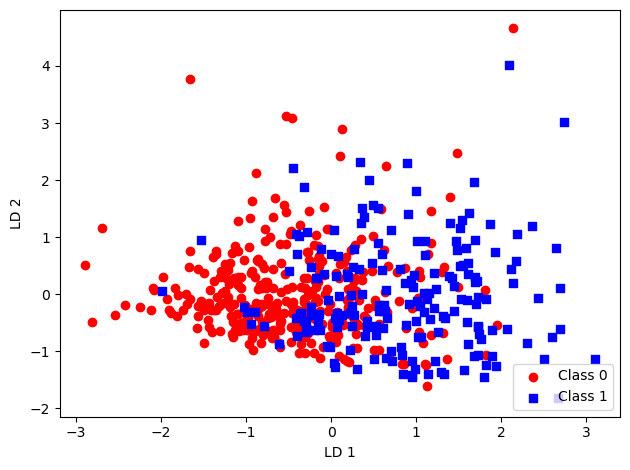

In [19]:
# Visualize the transformed  training dataset in a two-dimensional scatterplot
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1],
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [20]:
# Auxiliar function to plot the decision regions
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')

## LDA via scikit-learn

In [21]:
# scikit-learn
# Initializing the LDA transformer
lda = LDA(n_components=1)

# Initializing the logistic regression estimator:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs') # ovr = One-vs-Rest, lbfgs = Limited-memory Broyden-Fletcher-Goldfarb-Shanno

# Dimensionality reduction
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

# Fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_lda, y_train)

# Plotting the decision regions in the reduced space for the training dataset
# plot_decision_regions(X_train_lda, y_train, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()

/home/aalberto/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr', random_state=1)

In [22]:
# scikit-learn
# Plotting the decision regions in the reduced space for the test dataset
# plot_decision_regions(X_test_lda, y_test, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()

# Summary

---

Readers may ignore the next cell.

In [23]:
# Run a command in the terminal from a Python environment (such as a Jupyter Notebook or a 
# script that allows system commands to convert a Jupyter notebook to a file Python script. 
# * !
# This symbol is used in environments such as Jupyter Notebooks to execute system commands 
# operational directly from the notebook. In this case, the command is an execution of a 
# Python Script.
# * python ../.convert_notebook_to_script.py
# This command runs a Python script called convert_notebook_to_script.py. This file 
# is located in the previous directory (../ indicates that it is one level up in the system 
# files). The purpose of this script is to convert a Jupyter notebook (.ipynb) into a 
# Python script file (.py).
# * --input ex07.ipynb
# This is an option or argument that tells the script what the input file is, in this 
# case, the notebook ex07.ipynb.
# * --output ex07.py
# This option tells the script to save the output (the converted file) with the name
# ex07.py, which is a Python script.

! python ../.convert_notebook_to_script.py --input ex07.ipynb --output ex07.py

[NbConvertApp] Converting notebook ex07.ipynb to script
[NbConvertApp] Writing 11468 bytes to ex07.py
